# Interactive line plots with ensemble forecasts

This example demonstrates how to create **interactive** line plots with **earthkit-plots**, combining past observations and ensemble forecasts of temperature.

# Example: Temperature in Zurich

In this example, we use the [Open-Meteo API](https://open-meteo.com/) to fetch temperature observations and forecasts for Zurich from the MeteoSwiss ICON-CH1 model.

We start by downloading data for the last two days of observations and the next day of ensemble forecasts from the Open-Meteo API.  
The `requests_cache` and `retry_requests` libraries ensure that our requests are cached and retried automatically.

In [1]:
from datetime import datetime, timedelta

today = datetime.now()
yesterday = today - timedelta(days=1)
two_days_ago = today - timedelta(days=2)

today_str = today.strftime('%Y-%m-%d')
yesterday_str = yesterday.strftime('%Y-%m-%d')
two_days_ago_str = two_days_ago.strftime('%Y-%m-%d')

In [2]:
import requests_cache
from retry_requests import retry
import openmeteo_requests
from openmeteo_sdk.Variable import Variable

cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# Forecast data
ensemble_url = "https://ensemble-api.open-meteo.com/v1/ensemble"
ensemble_params = {
    "latitude": 47.4583,
    "longitude": 8.5480,
    "start_date": yesterday_str,
    "end_date": today_str,
    "hourly": "temperature_2m",
    "models": "meteoswiss_icon_ch1",
}
ensemble_response = openmeteo.weather_api(ensemble_url, params=ensemble_params)[0]
print("Fetched ensemble data for Zurich.")

Fetched ensemble data for Zurich.


In [3]:
# Past data
archive_url = "https://archive-api.open-meteo.com/v1/archive"
archive_params = {
    "latitude": 47.4583,
    "longitude": 8.5480,
    "start_date": two_days_ago_str,
    "end_date": yesterday_str,
    "hourly": "temperature_2m",
}
archive_response = openmeteo.weather_api(archive_url, params=archive_params)[0]
print("Fetched archive data for Zurich.")

Fetched archive data for Zurich.


## Processing the forecast

We store each ensemble member in a separate column of a `pandas.DataFrame`, which allows us to later calculate statistics such as the 5th percentile, 95th percentile, and the median forecast.

In [4]:
import pandas as pd

# Process forecast data
forecast_hourly = ensemble_response.Hourly()

forecast_data = {
    "date": pd.date_range(
        start=pd.to_datetime(forecast_hourly.Time(), unit="s", utc=True),
        end=pd.to_datetime(forecast_hourly.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=forecast_hourly.Interval()),
        inclusive="left"
    )
}

for i in range(forecast_hourly.VariablesLength()):
    variable = forecast_hourly.Variables(i)
    member = variable.EnsembleMember()
    forecast_data[f"temperature_2m_member_{member}"] = variable.ValuesAsNumpy()

forecast_df = pd.DataFrame(forecast_data)

## Processing the observations

For the same location, we also fetch archived temperature observations.  
These are stored in a similar `pandas.DataFrame`, with a `date` column for alignment.

In [5]:
# Process archive data
archive_hourly = archive_response.Hourly()
archive_temp_data = archive_hourly.Variables(0).ValuesAsNumpy()

archive_time_index = pd.date_range(
    start=pd.to_datetime(archive_hourly.Time(), unit="s", utc=True),
    periods=len(archive_temp_data),
    freq=pd.Timedelta(seconds=archive_hourly.Interval())
)

archive_df = pd.DataFrame(data={
    "date": archive_time_index,
    "temperature_2m_observed": archive_temp_data
})

## Merging observations and forecast

We merge the observations and the ensemble forecast into a single dataset.  
This ensures a continuous time axis where we can show both past and future values on the same plot.

In [6]:
# Merge the DataFrames
combined_df = (pd.merge(archive_df, forecast_df, on="date", how="outer")
                 .sort_values("date").reset_index(drop=True))

combined_df["date"] = (pd.to_datetime(combined_df["date"], utc=True)
                         .dt.tz_convert("Europe/Zurich")
                         .dt.tz_localize(None))

pd.concat([combined_df.head(2), combined_df.tail(2)])

,date,temperature_2m_observed,temperature_2m_member_0,temperature_2m_member_1,temperature_2m_member_2,temperature_2m_member_3,temperature_2m_member_4,temperature_2m_member_5,temperature_2m_member_6,temperature_2m_member_7,temperature_2m_member_8,temperature_2m_member_9,temperature_2m_member_10
0,2025-08-27 02:00:00,18.490000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-08-27 03:00:00,17.689999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,2025-08-30 00:00:00,NaN,15.2195,16.6695,16.119501,14.9695,15.5695,15.369500,15.169499,15.4695,16.3195,14.8195,15.5695
71,2025-08-30 01:00:00,NaN,15.2695,16.3195,15.719500,15.0195,15.5695,15.169499,14.869500,15.2695,15.7695,14.8195,15.8695


Convert the `date` column and values into plain Python lists (`x_obs`, `y_obs`), which are required by the plotting methods in `earthkit.plots.interactive.Chart`.

In [7]:
# Prepare data for plotting
past_df = combined_df[["date", "temperature_2m_observed"]].dropna()
member_columns = [c for c in combined_df.columns if "member" in c]
forecast_df_ok = combined_df[["date"] + member_columns].dropna(subset=member_columns, how="all")

x_obs = past_df["date"].dt.to_pydatetime().tolist()
y_obs = past_df["temperature_2m_observed"].astype(float).tolist()

/tmp/ipykernel_49735/2285448420.py:6: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  x_obs = past_df["date"].dt.to_pydatetime().tolist()


## Calculating ensemble statistics

To visualise the forecast uncertainty, we calculate:
- the **5th percentile** (lower bound),
- the **95th percentile** (upper bound),
- and the **median** of the ensemble.

These values form the shaded uncertainty band and central line in the plot.

In [8]:
import numpy as np

x_fcst = forecast_df_ok["date"].dt.to_pydatetime().tolist()
Y_fcst = forecast_df_ok[member_columns].to_numpy(dtype=float)
p5_vals  = np.nanpercentile(Y_fcst, 5, axis=1) if Y_fcst.size else np.array([])
p95_vals = np.nanpercentile(Y_fcst, 95, axis=1) if Y_fcst.size else np.array([])
med_vals = np.nanmedian(Y_fcst, axis=1) if Y_fcst.size else np.array([])

/tmp/ipykernel_49735/2981068000.py:3: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  x_fcst = forecast_df_ok["date"].dt.to_pydatetime().tolist()


## Plotting the results

Finally, we use `earthkit.plots.interactive.Chart` to draw:
- a **red line** for past observations,
- a **shaded band** for the 5-95% ensemble spread,
- a **thick line** for the ensemble median,
- faint lines for each individual ensemble member,
- and a **blue dashed vertical line** to separate observations from forecasts.

The result is an interactive plot where the user can explore uncertainty in the forecast relative to the past.

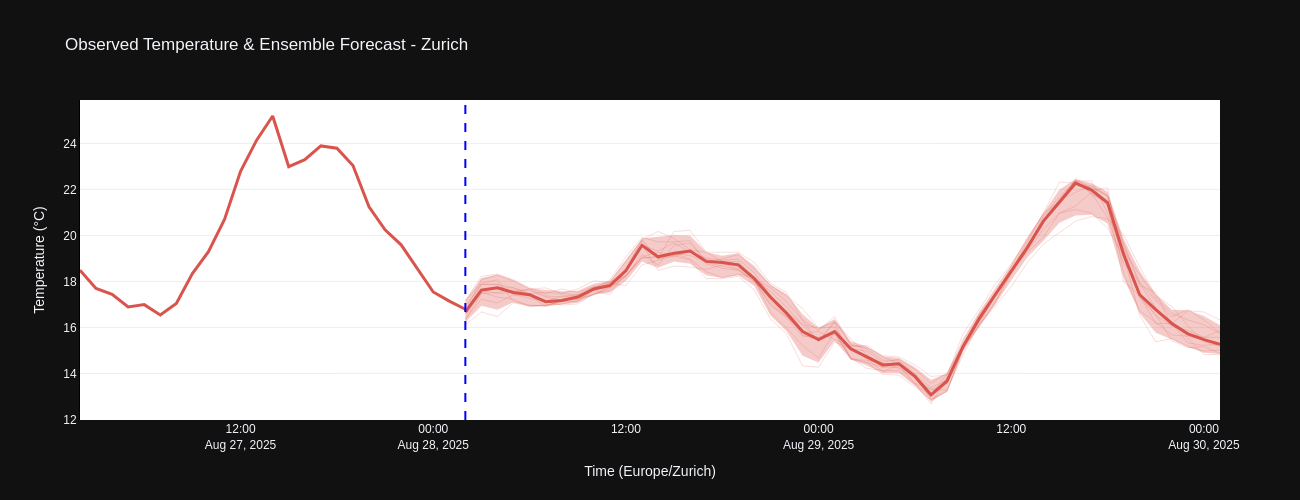

In [9]:
from earthkit.plots.interactive import Chart

chart= Chart()

chart.title("Observed Temperature & Ensemble Forecast - Zurich")

# Observed
if x_obs:
    chart.line(x=x_obs, y=y_obs, line_color="rgb(217, 84, 77)", line_width=3, name="Observed")

# Spread band
if len(x_fcst) and p5_vals.size and p95_vals.size:
    chart.line(x=x_fcst, y=p95_vals, line_width=0, showlegend=False)
    chart.line(x=x_fcst, y=p5_vals, line_width=0, fill="tonexty",
               fillcolor="rgba(217, 84, 77, 0.3)", showlegend=False, name="5-95% Spread")

# Median
if len(x_fcst) and med_vals.size:
    chart.line(x=x_fcst, y=med_vals, line_color="rgb(217, 84, 77)", line_width=3, name="Forecast Median")

# Individual members
if Y_fcst.size:
    for i in range(Y_fcst.shape[1]):
        chart.line(x=x_fcst, y=Y_fcst[:, i],
                   line_color="rgb(217, 84, 77)", opacity=0.2, line_width=1, showlegend=False)

# Boundary line
if x_obs:
    chart.fig.add_vline(x=max(x_obs), line_dash="dash", line_color="blue", line_width=2)

# Axes/layout
chart.fig.update_xaxes(type="date", title_text="Time (Europe/Zurich)")
chart.fig.update_yaxes(title_text="Temperature (°C)")
chart.fig.update_layout(template="plotly_dark")

# Render
chart.show(renderer="png",width=1300, height=500)